In [1]:
import numpy as np
import sympy
import scipy
from scipy.optimize import curve_fit
from typing import Union
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class LinearModel:
    def __init__(self, modelspec: np.ndarray, X: np.ndarray, y: np.ndarray, coefficients: np.ndarray, residuals: np.ndarray):
        if isinstance(modelspec, str):
            modelspec = model_matrix(name=modelspec, factors=X.shape[1])
        self.modelspec = modelspec
        self.X = X
        self.y = y
        self.coefficients = coefficients
        self.residuals = residuals

    def predict(self, X: Union[list, np.ndarray]) -> np.ndarray:
        """
        Returns the predicted response of a multiple linear regression model with given coefficients, for the data matrix X.

        Parameters
        ----------
        X : np.ndarray
            The matrix of predictors.

        Returns
        -------
        np.ndarray
            The predicted response.
        """
        if isinstance(X, list):
            X = np.array(X)
        if len(np.shape(X)) == 1:
            X = X.reshape(-1, 1)
        XX = x2fx(X=X, modelspec=self.modelspec)
        return XX @ self.coefficients
    
    def relative_effect(self) -> np.ndarray:
        """
        Returns the relative effect of each predictor variable on the response variable.

        Returns
        -------
        np.ndarray
            The relative effect of each factor, normalized by the effect of the constant term.
        """
        XX = x2fx(X=self.X, modelspec=self.modelspec)
        delta = XX.max(axis=0) - XX.min(axis=0)
        a0 = self.coefficients[0]
        return self.coefficients[1:] * delta[1:] / a0
    
    def rmse(self) -> float:
        """
        Returns the root mean squared error of the model.

        Returns
        -------
        float
            The root mean squared error of the model.
        """
        return np.sqrt(np.mean((self.y - self.predict(X=self.X)) ** 2))
    
    def coef_names(self) -> list:
        """
        Returns the names of the coefficients of a model.

        Returns
        -------
        list
            The names of the coefficients.
        """
        names = []
        for row in self.modelspec:
            name = ""
            for i, power in enumerate(row):
                if power == 0:
                    continue
                elif power == 1:
                    name += f":x{i+1}"
                else:
                    name += f":x{i+1}^{power}"
            if name == "":
                name = ":x0"
            names.append(name[1:])
        return names
        

def model_matrix(name: str, factors: int) -> np.ndarray:
    """
    Returns a model matrix for a given model name and number of factors.

    Parameters
    ----------
    name : str
        The name of the model. Can be one of "linear", "interaction", "quadratic", "purequadratic".
    factors : int
        The number of factors.

    Returns
    -------
    np.ndarray
        The model matrix.
    """
    constant = np.zeros(shape=(1, factors))
    linear = np.eye(N=factors)
    interaction = np.array([x for x in sympy.utilities.iterables.multiset_permutations([0] * (factors-2) + [1] * 2)])[::-1]
    quadratic = 2 * np.eye(N=factors)

    if name == "linear":
        return np.append(constant, linear, axis=0).astype(int)
    elif name == "interaction":
        return np.append(np.append(constant, linear, axis=0), interaction, axis=0).astype(int)
    elif name == "quadratic":
        return np.append(np.append(np.append(constant, linear, axis=0), interaction, axis=0), quadratic, axis=0).astype(int)
    elif name == "purequadratic":
        return np.append(np.append(constant, linear, axis=0), quadratic, axis=0).astype(int)
    else:
        raise ValueError("Invalid model name.")
    
def x2fx(X: Union[list, np.ndarray], modelspec: Union[str, list, np.ndarray]) -> np.ndarray:
    """
    Converts a matrix of predictors X to a design matrix D for regression analysis. Distinct predictor variables should appear in different columns of X.

    Parameters
    ----------
    X : Union[list, np.ndarray]
        The matrix of predictors.
    model : Union[str, list, np.ndarray]
        The model matrix.

    Returns
    -------
    np.ndarray
        The design matrix.
    """

    if isinstance(X, list):
        X = np.array(X)
    if isinstance(modelspec, str):
        modelspec = model_matrix(name=modelspec, factors=X.shape[1])
    elif isinstance(modelspec, list):
        modelspec = np.array(modelspec)
    elif isinstance(modelspec, np.ndarray):
        assert X.shape[1] == modelspec.shape[1], "The number of columns in 'X' and 'model' must be equal."

    M = np.ones(shape=(X.shape[0], modelspec.shape[0]))
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            for alpha in range(X.shape[1]):
                M[i, j] *= X[i, alpha] ** modelspec[j, alpha]

    return M

def fitlm(X: Union[list, np.ndarray], y: Union[list, np.ndarray], modelspec: Union[str, list, np.ndarray] = "linear") -> LinearModel:
    """
    Returns the linear model fit to the data matrix X.

    Parameters
    ----------
    X : Union[list, np.ndarray]
        The matrix of inputs.
    y : Union[list, np.ndarray]
        The response vector.
    modelspec : Union[str, list, np.ndarray]
        The model matrix.

    Returns
    -------
    LinearModel
        The fitted linear model.
    """
    if isinstance(X, list):
        X = np.array(X)
    if isinstance(y, list):
        y = np.array(y).reshape(-1, 1)
    XX = x2fx(X, modelspec)
    coefficients, residuals, _, _ = np.linalg.lstsq(XX, y, rcond=None)
    coefficients = coefficients.reshape(-1)
    return LinearModel(modelspec=modelspec, X=X, y=y, coefficients=coefficients, residuals=residuals)

def normplot(data: Union[list, np.ndarray]) -> Union[plt.Figure, plt.Axes]:
    """
    Returns a normal probability plot of the data.
    
    Parameters
    ----------
    data : Union[list, np.ndarray]
        The data to plot.
        
    Returns
    -------
    Union[plt.Figure, plt.Axes]
        The figure and axes of the plot.
    """
    def f(x, a, b):
        return np.exp(a + b * x) / (1 + np.exp(a + b * x))
    if isinstance(data, list):
        data = np.array(data)
    data = np.sort(data)
    X = data
    Y = np.linspace(0, 1, len(X)+2)[1:-1]
    fig, ax = plt.subplots()
    ax.plot(X, Y, "k+")
    ylim = ax.get_ylim()
    popt, _ = scipy.optimize.curve_fit(f, X, Y, sigma=X)
    X_fit = np.linspace(start=X.min(), stop=X.max(), num=10)
    Y_fit = f(X_fit, *popt)
    X_fit = X_fit[(Y_fit > 0) & (Y_fit < 1)]
    Y_fit = Y_fit[(Y_fit > 0) & (Y_fit < 1)]
    ax.plot(X_fit, Y_fit, "r-")
    ax.set_yscale("logit")
    ax.set_ylim(ylim)
    plt.xlabel("Data")
    plt.ylabel("Probability")

In [24]:
X = pd.read_csv("data.csv", sep=";", decimal=",").values[:, :-1]

y = pd.read_csv("data.csv", sep=";", decimal=",").values[:, -1]

model = fitlm(X, y, "quadratic")

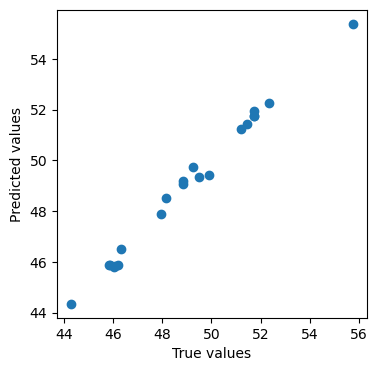

In [25]:
y_pred = model.predict(np.array(X))

plt.figure(figsize=(4, 4), dpi=100)
plt.plot(y, y_pred, "o")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

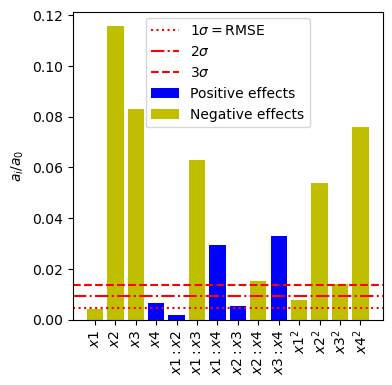

In [26]:
plt.figure(figsize=(4, 4), dpi=100)
x_to_plot = np.arange(start=1, stop=len(model.coefficients))
y_to_plot = model.relative_effect()
plt.bar(x_to_plot[y_to_plot>0], y_to_plot[y_to_plot>0], color="b", label="Positive effects")
plt.bar(x_to_plot[y_to_plot<0], -y_to_plot[y_to_plot<0], color="y", label="Negative effects")
plt.axhline(y=1*model.rmse() / model.coefficients[0], color="red", linestyle=":", label="$1\\sigma=$RMSE")
plt.axhline(y=2*model.rmse() / model.coefficients[0], color="red", linestyle="-.", label="$2\\sigma$")
plt.axhline(y=3*model.rmse() / model.coefficients[0], color="red", linestyle="--", label="$3\\sigma$")
plt.xticks(ticks=x_to_plot, labels=[f"${name}$" for name in model.coef_names()[1:]], rotation=90)
plt.legend()
plt.ylabel("$a_i / a_0$")
plt.show()

In [27]:
model.residuals

array([1.1729267])

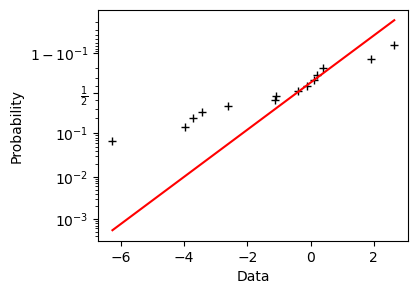

In [63]:
fig, ax = normplot(data=model.coefficients[1:])
fig.set_size_inches(4, 3)
fig.set_dpi(100)

In [6]:
X = np.array([ 1.04026206e+00,  2.94589381e-05,  1.74874711e-02, -4.81006188e-03, -8.15806496e-03, -9.95566210e-01])

In [8]:
normplot(data=X)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Data', ylabel='Probability'>)

/Users/Julien/opt/anaconda3/lib/python3.9/site-packages/matplotlib/ticker.py:2803: RuntimeWarning: divide by zero encountered in log10
  else -np.floor(np.log10(1 - vmax))


Error in callback <function _draw_all_if_interactive at 0x1479c8670> (for post_execute):


OverflowError: cannot convert float infinity to integer

OverflowError: cannot convert float infinity to integer

<Figure size 640x480 with 1 Axes>

Text(0, 0.5, 'Probability')

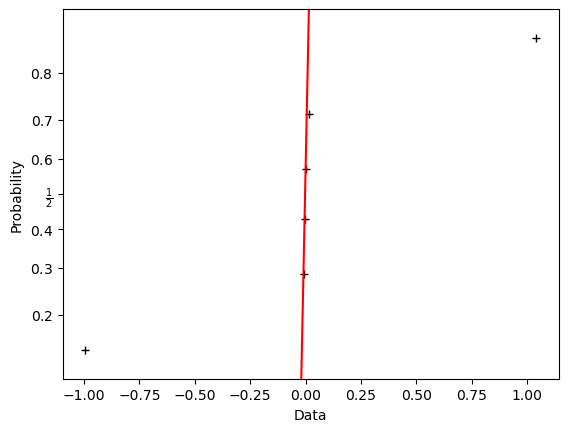

In [28]:
data = X



In [15]:
popt, _ = curve_fit(f, X, Y, sigma=X)

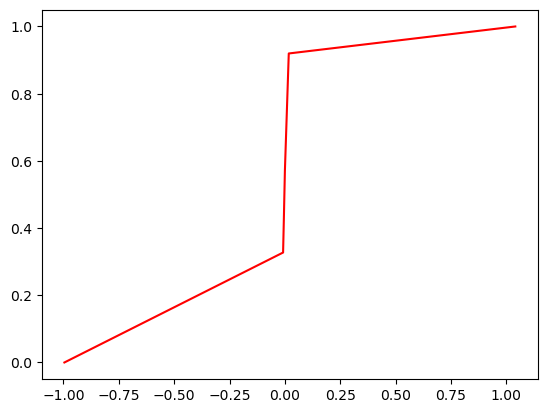

In [23]:
fig, ax = plt.subplots()
ax.plot(X, f(X, *popt), "r-")
ax.set_yscale("logit")

In [24]:
f(X, *popt)

array([7.44237030e-54, 3.27235322e-01, 4.23513261e-01, 5.71428098e-01,
       9.19668626e-01, 1.00000000e+00])